# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

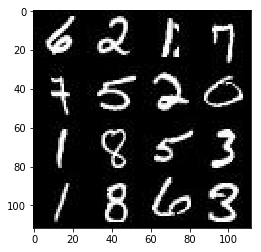

In [2]:
show_n_images = 24

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

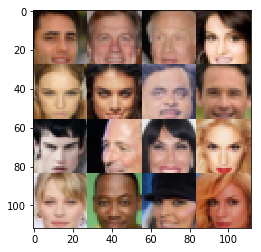

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='lr')

    return real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/pedro/an

### Custom helper functions 

In [15]:

def leaky_relu(x, alpha, name='leaky_relu'):
    return tf.maximum(x * alpha, x, name=name)

def smooth_labels(logits, smooth=0.1):
    return tf.ones_like(logits) * (1 - smooth)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [86]:
def discriminator(images, reuse=False, alpha=0.02, keep_prob=0.9):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, 
                              strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = leaky_relu(x1, alpha)
        
        x2 = tf.layers.conv2d(x1, 128, 5, 
                              strides=2, 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2, alpha)
        
        x3 = tf.layers.conv2d(x2, 256, 5, 
                              strides=2, 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3, alpha)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=(1 - keep_prob))
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [87]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, (7*7*256))

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha)
        
        # This gives us error: Generator output (is_train=True) has wrong shape.  Found [None, 56, 56, 5]
        # x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        # x3 = tf.layers.batch_normalization(x3, training=is_train)
        # x3 = leaky_relu(x3, alpha)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.layers.dropout(logits, rate=1-keep_prob, training=is_train)
        # 28x28x3 now
        
        return tf.tanh(logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [88]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.02):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=smooth_labels(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [89]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [90]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [91]:
import datetime

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    ## THIS METHOD IS HEAVILY INSPIRED BY THE TRAIN METHOD FROM DCGAN-SVHN LESSON
    show_every_n_steps, print_every, n_images = 100, 20, 25
    
    # Set the alpha for leaky ReLu's
    alpha = 0.2
    
    
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    desc_loss, gen_loss = model_loss(real_input, z_input, data_shape[3], alpha=alpha)
    
    d_train, g_train = model_opt(desc_loss, gen_loss, lr, beta1)
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_count = 0
            for batch_images in get_batches(batch_size):
                batch_count += 1
                
                # Re-scale images to be in the range of -1 to 1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train, feed_dict={real_input: batch_images, 
                                                 z_input: batch_z, 
                                                 lr: learning_rate})
                
                _ = sess.run(g_train, feed_dict={z_input: batch_z, 
                                                 real_input: batch_images, 
                                                 lr: learning_rate})
                
                if batch_count % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = desc_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = gen_loss.eval({z_input: batch_z})
                    date_time = datetime.datetime.now()
                    

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g),
                          "TS: {}".format(date_time))
                
                if batch_count % show_every_n_steps == 0:
                    show_generator_output(sess, n_images, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 2.2430... TS: 2017-08-24 11:15:46.721495
Epoch 1/2... Discriminator Loss: 0.3776... Generator Loss: 4.3628... TS: 2017-08-24 11:15:48.000980
Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 6.2653... TS: 2017-08-24 11:15:49.288801
Epoch 1/2... Discriminator Loss: 0.3373... Generator Loss: 7.0716... TS: 2017-08-24 11:15:50.563955
Epoch 1/2... Discriminator Loss: 0.3598... Generator Loss: 6.0650... TS: 2017-08-24 11:15:51.847833


Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 7.8910... TS: 2017-08-24 11:15:53.518334
Epoch 1/2... Discriminator Loss: 0.3497... Generator Loss: 7.5527... TS: 2017-08-24 11:15:54.792899
Epoch 1/2... Discriminator Loss: 0.3299... Generator Loss: 7.9482... TS: 2017-08-24 11:15:56.073752
Epoch 1/2... Discriminator Loss: 0.3322... Generator Loss: 7.7065... TS: 2017-08-24 11:15:57.357002
Epoch 1/2... Discriminator Loss: 0.3309... Generator Loss: 8.2985... TS: 2017-08-24 11:15:58.644526


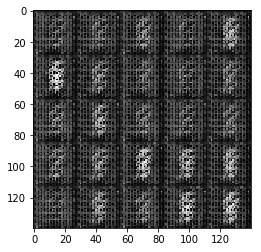

Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 8.1035... TS: 2017-08-24 11:16:00.307430
Epoch 1/2... Discriminator Loss: 0.3349... Generator Loss: 8.3371... TS: 2017-08-24 11:16:01.586579
Epoch 1/2... Discriminator Loss: 0.3281... Generator Loss: 8.3024... TS: 2017-08-24 11:16:02.866353
Epoch 1/2... Discriminator Loss: 0.3266... Generator Loss: 8.5133... TS: 2017-08-24 11:16:04.168987
Epoch 1/2... Discriminator Loss: 0.3265... Generator Loss: 8.3825... TS: 2017-08-24 11:16:05.453401


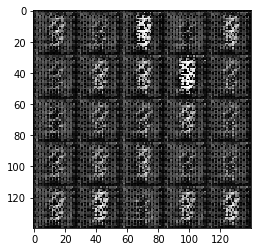

Epoch 1/2... Discriminator Loss: 0.3327... Generator Loss: 8.0942... TS: 2017-08-24 11:16:07.144857
Epoch 1/2... Discriminator Loss: 0.3376... Generator Loss: 8.8715... TS: 2017-08-24 11:16:08.450299
Epoch 1/2... Discriminator Loss: 0.3329... Generator Loss: 8.5568... TS: 2017-08-24 11:16:09.745886
Epoch 1/2... Discriminator Loss: 0.3381... Generator Loss: 9.2083... TS: 2017-08-24 11:16:11.016942
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 8.9334... TS: 2017-08-24 11:16:12.295163


Epoch 1/2... Discriminator Loss: 0.3348... Generator Loss: 8.4535... TS: 2017-08-24 11:16:13.963059
Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 8.4684... TS: 2017-08-24 11:16:15.234519
Epoch 1/2... Discriminator Loss: 0.3286... Generator Loss: 9.0189... TS: 2017-08-24 11:16:16.528868
Epoch 1/2... Discriminator Loss: 0.3352... Generator Loss: 6.3041... TS: 2017-08-24 11:16:17.804089
Epoch 1/2... Discriminator Loss: 0.3419... Generator Loss: 8.2222... TS: 2017-08-24 11:16:19.087977


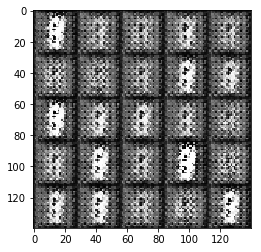

Epoch 1/2... Discriminator Loss: 0.3415... Generator Loss: 8.1959... TS: 2017-08-24 11:16:20.771802
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 7.7712... TS: 2017-08-24 11:16:22.048247
Epoch 1/2... Discriminator Loss: 0.3497... Generator Loss: 8.3844... TS: 2017-08-24 11:16:23.357688
Epoch 1/2... Discriminator Loss: 0.3385... Generator Loss: 8.6080... TS: 2017-08-24 11:16:24.664719
Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 8.7719... TS: 2017-08-24 11:16:25.980534


Epoch 1/2... Discriminator Loss: 0.3362... Generator Loss: 7.8810... TS: 2017-08-24 11:16:27.673794
Epoch 1/2... Discriminator Loss: 0.3347... Generator Loss: 7.7714... TS: 2017-08-24 11:16:28.978567
Epoch 1/2... Discriminator Loss: 0.3301... Generator Loss: 8.7900... TS: 2017-08-24 11:16:30.270279
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 9.1841... TS: 2017-08-24 11:16:31.553638
Epoch 1/2... Discriminator Loss: 0.3267... Generator Loss: 8.7497... TS: 2017-08-24 11:16:32.872195


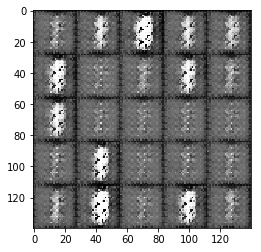

Epoch 1/2... Discriminator Loss: 0.3341... Generator Loss: 8.7681... TS: 2017-08-24 11:16:34.581730
Epoch 1/2... Discriminator Loss: 0.3318... Generator Loss: 8.8442... TS: 2017-08-24 11:16:35.865253
Epoch 1/2... Discriminator Loss: 0.3294... Generator Loss: 9.5120... TS: 2017-08-24 11:16:37.171678
Epoch 1/2... Discriminator Loss: 0.3299... Generator Loss: 8.7051... TS: 2017-08-24 11:16:38.476291
Epoch 1/2... Discriminator Loss: 0.3432... Generator Loss: 8.3621... TS: 2017-08-24 11:16:39.748281


Epoch 1/2... Discriminator Loss: 0.3360... Generator Loss: 8.8427... TS: 2017-08-24 11:16:41.419703
Epoch 1/2... Discriminator Loss: 0.3395... Generator Loss: 8.6238... TS: 2017-08-24 11:16:42.714712
Epoch 1/2... Discriminator Loss: 0.3342... Generator Loss: 9.1670... TS: 2017-08-24 11:16:44.026686
Epoch 1/2... Discriminator Loss: 0.3255... Generator Loss: 9.2127... TS: 2017-08-24 11:16:45.309357
Epoch 1/2... Discriminator Loss: 0.3353... Generator Loss: 9.4995... TS: 2017-08-24 11:16:46.599132


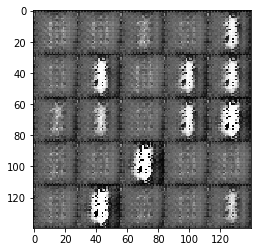

Epoch 1/2... Discriminator Loss: 0.3320... Generator Loss: 9.3967... TS: 2017-08-24 11:16:48.260590
Epoch 2/2... Discriminator Loss: 0.3268... Generator Loss: 8.9041... TS: 2017-08-24 11:16:50.637912
Epoch 2/2... Discriminator Loss: 0.3441... Generator Loss: 8.9381... TS: 2017-08-24 11:16:51.940068
Epoch 2/2... Discriminator Loss: 0.3269... Generator Loss: 8.7485... TS: 2017-08-24 11:16:53.238720
Epoch 2/2... Discriminator Loss: 0.3254... Generator Loss: 9.3774... TS: 2017-08-24 11:16:54.563879
Epoch 2/2... Discriminator Loss: 0.3711... Generator Loss: 7.9088... TS: 2017-08-24 11:16:55.873922


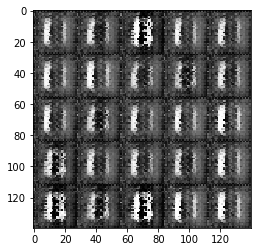

Epoch 2/2... Discriminator Loss: 0.3340... Generator Loss: 8.8258... TS: 2017-08-24 11:16:57.572665
Epoch 2/2... Discriminator Loss: 0.3280... Generator Loss: 9.4100... TS: 2017-08-24 11:16:58.878930
Epoch 2/2... Discriminator Loss: 0.3317... Generator Loss: 9.4094... TS: 2017-08-24 11:17:00.169933
Epoch 2/2... Discriminator Loss: 0.3424... Generator Loss: 9.2786... TS: 2017-08-24 11:17:01.497863
Epoch 2/2... Discriminator Loss: 0.3302... Generator Loss: 9.2538... TS: 2017-08-24 11:17:02.798324


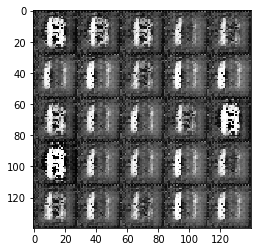

Epoch 2/2... Discriminator Loss: 0.3256... Generator Loss: 9.6900... TS: 2017-08-24 11:17:04.504285
Epoch 2/2... Discriminator Loss: 0.3328... Generator Loss: 9.6115... TS: 2017-08-24 11:17:05.795637
Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 9.8476... TS: 2017-08-24 11:17:07.088089
Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 9.7751... TS: 2017-08-24 11:17:08.379437
Epoch 2/2... Discriminator Loss: 0.3356... Generator Loss: 8.9729... TS: 2017-08-24 11:17:09.676340


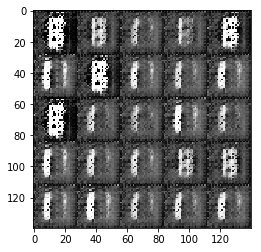

Epoch 2/2... Discriminator Loss: 0.3331... Generator Loss: 8.9848... TS: 2017-08-24 11:17:11.428479
Epoch 2/2... Discriminator Loss: 0.3360... Generator Loss: 9.7629... TS: 2017-08-24 11:17:12.746108
Epoch 2/2... Discriminator Loss: 0.3277... Generator Loss: 9.4446... TS: 2017-08-24 11:17:14.041555
Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 9.1288... TS: 2017-08-24 11:17:15.351018
Epoch 2/2... Discriminator Loss: 0.3364... Generator Loss: 9.1390... TS: 2017-08-24 11:17:16.633348


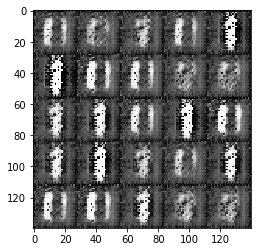

Epoch 2/2... Discriminator Loss: 0.3302... Generator Loss: 9.5899... TS: 2017-08-24 11:17:18.344322
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 9.6219... TS: 2017-08-24 11:17:19.660337
Epoch 2/2... Discriminator Loss: 0.3284... Generator Loss: 9.8962... TS: 2017-08-24 11:17:20.943832
Epoch 2/2... Discriminator Loss: 0.3398... Generator Loss: 8.9929... TS: 2017-08-24 11:17:22.271130
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 9.1668... TS: 2017-08-24 11:17:23.567899


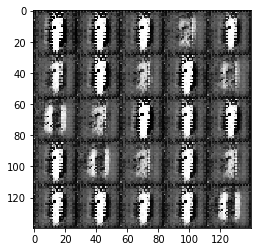

Epoch 2/2... Discriminator Loss: 0.3259... Generator Loss: 9.7207... TS: 2017-08-24 11:17:25.277778
Epoch 2/2... Discriminator Loss: 0.3337... Generator Loss: 9.7328... TS: 2017-08-24 11:17:26.570321
Epoch 2/2... Discriminator Loss: 0.3303... Generator Loss: 9.6453... TS: 2017-08-24 11:17:27.867584
Epoch 2/2... Discriminator Loss: 0.3278... Generator Loss: 9.4956... TS: 2017-08-24 11:17:29.168997
Epoch 2/2... Discriminator Loss: 0.3273... Generator Loss: 10.0406... TS: 2017-08-24 11:17:30.447933


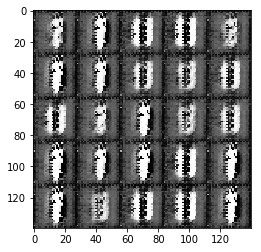

Epoch 2/2... Discriminator Loss: 0.3331... Generator Loss: 9.9424... TS: 2017-08-24 11:17:32.141260
Epoch 2/2... Discriminator Loss: 0.3295... Generator Loss: 10.0630... TS: 2017-08-24 11:17:33.460215
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 10.1412... TS: 2017-08-24 11:17:34.803035
Epoch 2/2... Discriminator Loss: 0.3306... Generator Loss: 9.9454... TS: 2017-08-24 11:17:36.083361
Epoch 2/2... Discriminator Loss: 0.3318... Generator Loss: 9.8226... TS: 2017-08-24 11:17:37.375214


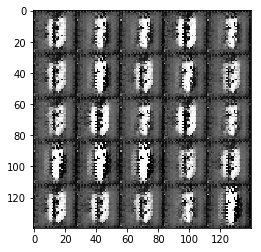

Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 9.9725... TS: 2017-08-24 11:17:39.120973
Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 9.8577... TS: 2017-08-24 11:17:40.415108
Epoch 2/2... Discriminator Loss: 0.3344... Generator Loss: 10.1569... TS: 2017-08-24 11:17:41.715743
Epoch 2/2... Discriminator Loss: 0.3388... Generator Loss: 9.2857... TS: 2017-08-24 11:17:43.014392
Epoch 2/2... Discriminator Loss: 0.3383... Generator Loss: 9.3707... TS: 2017-08-24 11:17:44.297597


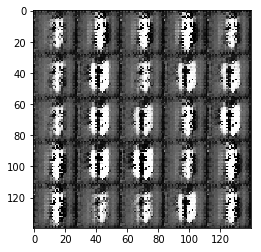

Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 9.6379... TS: 2017-08-24 11:17:45.986469
Epoch 2/2... Discriminator Loss: 0.3271... Generator Loss: 10.1145... TS: 2017-08-24 11:17:47.259905
Epoch 2/2... Discriminator Loss: 0.3320... Generator Loss: 10.0154... TS: 2017-08-24 11:17:48.582939
Epoch 2/2... Discriminator Loss: 0.3352... Generator Loss: 10.1088... TS: 2017-08-24 11:17:49.916113
Epoch 2/2... Discriminator Loss: 0.3292... Generator Loss: 10.0639... TS: 2017-08-24 11:17:51.237180


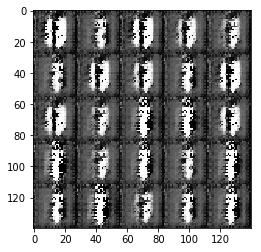

Epoch 2/2... Discriminator Loss: 0.3289... Generator Loss: 10.3055... TS: 2017-08-24 11:17:52.972696


In [92]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 6.8371... TS: 2017-08-24 11:25:19.592406
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 5.1125... TS: 2017-08-24 11:25:21.965647
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 5.5795... TS: 2017-08-24 11:25:24.251463
Epoch 1/1... Discriminator Loss: 0.5390... Generator Loss: 4.2174... TS: 2017-08-24 11:25:26.663017
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 5.0113... TS: 2017-08-24 11:25:29.046870


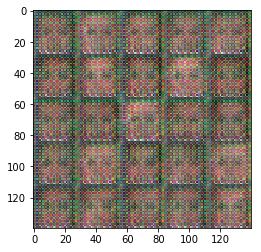

Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 6.3241... TS: 2017-08-24 11:25:31.828911
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 5.8913... TS: 2017-08-24 11:25:34.222301
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 6.8029... TS: 2017-08-24 11:25:36.616663
Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 5.6540... TS: 2017-08-24 11:25:39.026386
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 6.8336... TS: 2017-08-24 11:25:41.505696


Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 6.3514... TS: 2017-08-24 11:25:44.405086
Epoch 1/1... Discriminator Loss: 0.3296... Generator Loss: 6.6886... TS: 2017-08-24 11:25:46.804697
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 5.8824... TS: 2017-08-24 11:25:49.135834
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 6.9913... TS: 2017-08-24 11:25:51.552041
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 7.6731... TS: 2017-08-24 11:25:53.903712


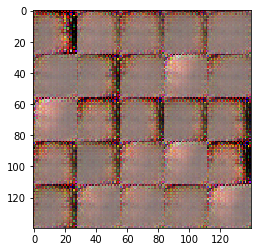

Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 6.8678... TS: 2017-08-24 11:25:56.716998
Epoch 1/1... Discriminator Loss: 0.3306... Generator Loss: 6.8785... TS: 2017-08-24 11:25:59.077330
Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 7.7693... TS: 2017-08-24 11:26:01.474445
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 7.4820... TS: 2017-08-24 11:26:03.928616
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 7.2215... TS: 2017-08-24 11:26:06.344903


Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 7.5164... TS: 2017-08-24 11:26:09.169145
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 7.5551... TS: 2017-08-24 11:26:11.564845
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 7.3412... TS: 2017-08-24 11:26:21.960843
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 7.6996... TS: 2017-08-24 11:26:34.282300
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 8.1144... TS: 2017-08-24 11:26:46.251145


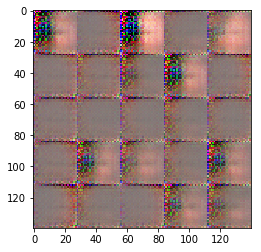

Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 7.7537... TS: 2017-08-24 11:26:59.080337
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 7.8772... TS: 2017-08-24 11:27:11.211056
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 7.7803... TS: 2017-08-24 11:27:23.265243
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 7.8332... TS: 2017-08-24 11:27:35.464449
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 7.8445... TS: 2017-08-24 11:27:47.295569


Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 8.0534... TS: 2017-08-24 11:28:00.060403
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 8.1917... TS: 2017-08-24 11:28:11.828136
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 8.2750... TS: 2017-08-24 11:28:24.045734
Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 8.1768... TS: 2017-08-24 11:28:36.550004
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 8.4843... TS: 2017-08-24 11:28:48.769078


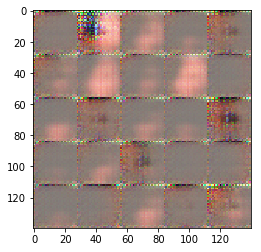

Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 8.2484... TS: 2017-08-24 11:29:07.642981
Epoch 1/1... Discriminator Loss: 0.3296... Generator Loss: 8.0507... TS: 2017-08-24 11:29:56.276455
Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 8.3716... TS: 2017-08-24 11:30:41.872804
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 8.3626... TS: 2017-08-24 11:31:25.378864
Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 8.6863... TS: 2017-08-24 11:32:03.358947


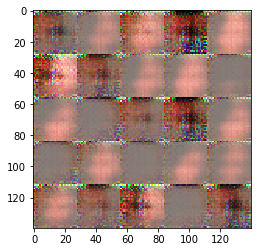

Epoch 1/1... Discriminator Loss: 0.3296... Generator Loss: 8.7458... TS: 2017-08-24 11:32:47.637643
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 8.5068... TS: 2017-08-24 11:33:39.119286
Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 8.4943... TS: 2017-08-24 11:34:22.942103
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 8.3817... TS: 2017-08-24 11:35:06.981591
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 8.8378... TS: 2017-08-24 11:35:19.156657


Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 8.9938... TS: 2017-08-24 11:35:31.239663
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 8.9133... TS: 2017-08-24 11:35:43.379487
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 8.6020... TS: 2017-08-24 11:35:55.421856
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 8.6337... TS: 2017-08-24 11:36:07.506427
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 8.0857... TS: 2017-08-24 11:36:19.517496


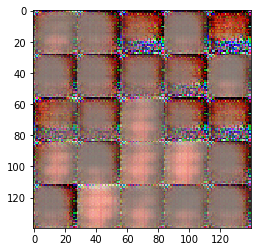

Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 9.0543... TS: 2017-08-24 11:36:31.875908
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 7.8374... TS: 2017-08-24 11:36:43.595015
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 8.6823... TS: 2017-08-24 11:36:55.564730
Epoch 1/1... Discriminator Loss: 0.3277... Generator Loss: 8.4756... TS: 2017-08-24 11:37:07.501002
Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 9.2321... TS: 2017-08-24 11:37:19.340109


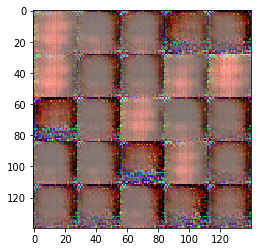

Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 8.9138... TS: 2017-08-24 11:37:31.185886
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 8.3619... TS: 2017-08-24 11:37:40.748172
Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 8.7874... TS: 2017-08-24 11:37:51.948696
Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 8.6198... TS: 2017-08-24 11:38:03.471544
Epoch 1/1... Discriminator Loss: 0.3296... Generator Loss: 9.2338... TS: 2017-08-24 11:38:14.879426


Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 9.1333... TS: 2017-08-24 11:38:27.575755
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 8.6564... TS: 2017-08-24 11:38:39.793752
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 8.8244... TS: 2017-08-24 11:38:51.588921
Epoch 1/1... Discriminator Loss: 0.3264... Generator Loss: 8.6970... TS: 2017-08-24 11:39:03.768810
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 9.3422... TS: 2017-08-24 11:39:15.575103


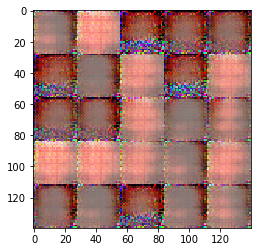

Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 9.0328... TS: 2017-08-24 11:39:28.553715
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 9.2548... TS: 2017-08-24 11:39:40.933077
Epoch 1/1... Discriminator Loss: 0.3328... Generator Loss: 8.9374... TS: 2017-08-24 11:39:53.030942
Epoch 1/1... Discriminator Loss: 0.3264... Generator Loss: 9.2836... TS: 2017-08-24 11:40:04.847269
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 9.1676... TS: 2017-08-24 11:40:16.644225


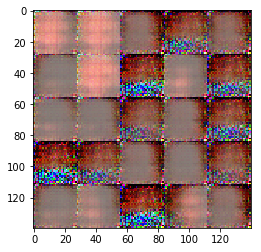

Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 8.7756... TS: 2017-08-24 11:40:29.421872
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 8.8728... TS: 2017-08-24 11:40:42.447133
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 8.9787... TS: 2017-08-24 11:40:55.526257
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 9.0560... TS: 2017-08-24 11:41:07.908685
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 8.8114... TS: 2017-08-24 11:41:21.388668


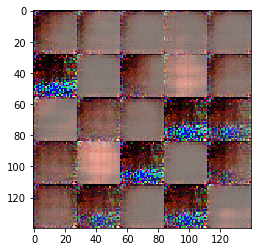

Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 8.9046... TS: 2017-08-24 11:41:34.526934
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 9.1756... TS: 2017-08-24 11:41:47.431425
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 8.6674... TS: 2017-08-24 11:41:59.790903
Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 8.8669... TS: 2017-08-24 11:42:13.042784
Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 8.8782... TS: 2017-08-24 11:42:25.446603


Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 8.3338... TS: 2017-08-24 11:42:38.205064
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 9.1409... TS: 2017-08-24 11:42:51.686002
Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 8.7471... TS: 2017-08-24 11:43:04.229229
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 8.4680... TS: 2017-08-24 11:43:16.372254
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 9.0842... TS: 2017-08-24 11:43:29.725190


Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 9.0755... TS: 2017-08-24 11:43:42.237815
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 9.3805... TS: 2017-08-24 11:43:54.981843
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 9.7517... TS: 2017-08-24 11:44:07.746578
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 8.9814... TS: 2017-08-24 11:44:19.878818
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 9.2873... TS: 2017-08-24 11:44:33.221732


Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 9.4702... TS: 2017-08-24 11:44:46.147791
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 8.9913... TS: 2017-08-24 11:44:58.422497
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 8.9950... TS: 2017-08-24 11:45:11.155144
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 9.0465... TS: 2017-08-24 11:45:23.681103
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 9.1100... TS: 2017-08-24 11:45:35.760602


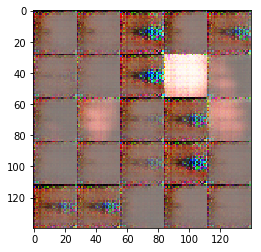

Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 8.8848... TS: 2017-08-24 11:45:49.462607
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 8.6878... TS: 2017-08-24 11:46:01.735842
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 9.0953... TS: 2017-08-24 11:46:13.943037
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 9.3823... TS: 2017-08-24 11:46:27.080937
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 9.1676... TS: 2017-08-24 11:46:39.388471


Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 9.4628... TS: 2017-08-24 11:46:53.120742
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 9.2499... TS: 2017-08-24 11:47:05.564267
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 9.4036... TS: 2017-08-24 11:47:18.298264
Epoch 1/1... Discriminator Loss: 0.3254... Generator Loss: 9.0464... TS: 2017-08-24 11:47:30.980600
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 9.1764... TS: 2017-08-24 11:47:43.148710


Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 9.3419... TS: 2017-08-24 11:47:56.820949
Epoch 1/1... Discriminator Loss: 0.3277... Generator Loss: 9.5054... TS: 2017-08-24 11:48:09.452742
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 9.6484... TS: 2017-08-24 11:48:21.399048
Epoch 1/1... Discriminator Loss: 0.3258... Generator Loss: 9.4181... TS: 2017-08-24 11:48:34.843773
Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 9.9923... TS: 2017-08-24 11:48:46.960973


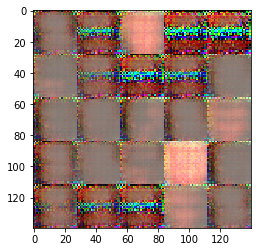

Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 9.5300... TS: 2017-08-24 11:49:00.449368
Epoch 1/1... Discriminator Loss: 0.3296... Generator Loss: 9.5458... TS: 2017-08-24 11:49:13.209005
Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 9.0511... TS: 2017-08-24 11:49:26.238617
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 9.7579... TS: 2017-08-24 11:49:38.845386
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 8.9256... TS: 2017-08-24 11:49:52.263123


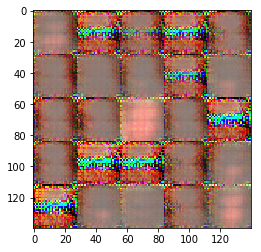

Epoch 1/1... Discriminator Loss: 0.3296... Generator Loss: 9.4994... TS: 2017-08-24 11:50:05.052160
Epoch 1/1... Discriminator Loss: 0.3268... Generator Loss: 9.8695... TS: 2017-08-24 11:50:17.044389
Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 9.6513... TS: 2017-08-24 11:50:35.605467
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 9.3326... TS: 2017-08-24 11:51:05.394925
Epoch 1/1... Discriminator Loss: 0.3268... Generator Loss: 9.9535... TS: 2017-08-24 11:51:43.132501


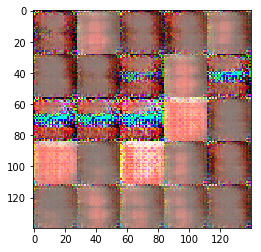

Epoch 1/1... Discriminator Loss: 0.3278... Generator Loss: 9.8951... TS: 2017-08-24 11:51:55.997935
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 9.2333... TS: 2017-08-24 11:52:09.688461
Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 9.7475... TS: 2017-08-24 11:52:22.231993
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 9.0811... TS: 2017-08-24 11:52:34.884286
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 9.6268... TS: 2017-08-24 11:52:48.047066


Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 8.8649... TS: 2017-08-24 11:53:00.905532
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 10.0037... TS: 2017-08-24 11:53:13.604105
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 9.6981... TS: 2017-08-24 11:53:26.609750
Epoch 1/1... Discriminator Loss: 0.3277... Generator Loss: 9.7269... TS: 2017-08-24 11:53:38.877075
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 9.0910... TS: 2017-08-24 11:53:51.175440


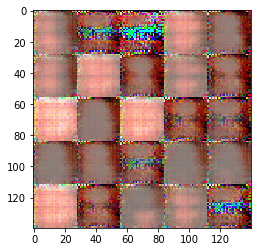

Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.9593... TS: 2017-08-24 11:54:05.670343
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 0.3676... TS: 2017-08-24 11:54:17.940564
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.7231... TS: 2017-08-24 11:54:32.596211
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 1.1452... TS: 2017-08-24 11:54:45.006945
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7149... TS: 2017-08-24 11:54:57.540382


Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.9816... TS: 2017-08-24 11:55:11.194121
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.1198... TS: 2017-08-24 11:55:23.250647
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.7328... TS: 2017-08-24 11:55:35.580377
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.8262... TS: 2017-08-24 11:55:48.819519
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 3.1162... TS: 2017-08-24 11:56:01.098056


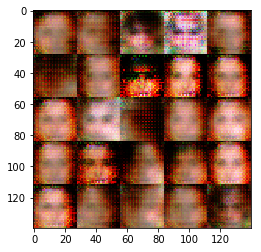

Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 4.5862... TS: 2017-08-24 11:56:13.862654
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 4.9038... TS: 2017-08-24 11:56:27.394801
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 5.4177... TS: 2017-08-24 11:56:39.629730
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 5.6196... TS: 2017-08-24 11:56:52.244555
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 5.8080... TS: 2017-08-24 11:57:05.001709


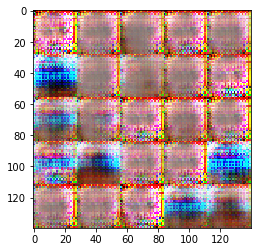

Epoch 1/1... Discriminator Loss: 0.3324... Generator Loss: 5.5371... TS: 2017-08-24 11:57:17.835168
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 6.2796... TS: 2017-08-24 11:57:30.041797
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 6.3603... TS: 2017-08-24 11:57:43.864319
Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 6.5078... TS: 2017-08-24 11:57:56.239014
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 7.5380... TS: 2017-08-24 11:58:08.151335


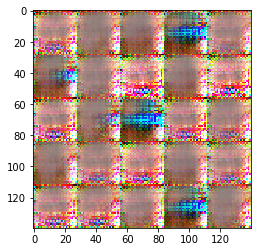

Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 6.2150... TS: 2017-08-24 11:58:22.157292
Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 7.3200... TS: 2017-08-24 11:58:34.665716
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 6.9892... TS: 2017-08-24 11:58:46.947907
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 7.1370... TS: 2017-08-24 11:59:00.988282
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 7.4790... TS: 2017-08-24 11:59:13.408678


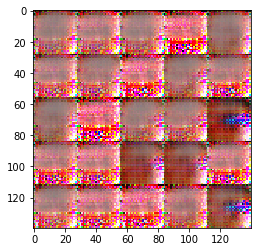

Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 6.5009... TS: 2017-08-24 11:59:27.924984
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 7.7484... TS: 2017-08-24 11:59:40.390048
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 7.7579... TS: 2017-08-24 11:59:53.045613


In [93]:
# Hyper parameters base on https://arxiv.org/pdf/1511.06434.pdf
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.4



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.